# Installs and imports

In [ ]:
! pip install datasets transformers 

In [ ]:
from datasets import load_dataset
from transformers import AutoTokenizer, AutoModelForSequenceClassification, DataCollatorWithPadding
import pandas as pd
import numpy as np
import torch 
import torch.nn as nn
import seaborn as sns
import matplotlib.pyplot as plt


# Data preparation.

**Loading emotions dataset from huggingface's datasets library**

**I am using Huggingface datasets library for following reasons**

*   many datasets are present.
*   The datasets can be easily preprocessed, tokenized and converted to dataframes to perform anaylsis.



In [ ]:
# loading emotions dataset from hugging face dataset libarary

emotions = load_dataset("emotion")



Downloading:   0%|          | 0.00/1.66k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/1.61k [00:00<?, ?B/s]

Using custom data configuration default


Downloading:   0%|          | 0.00/1.66M [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/204k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/207k [00:00<?, ?B/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

0 examples [00:00, ? examples/s]

Dataset emotion downloaded and prepared to /root/.cache/huggingface/datasets/emotion/default/0.0.0/348f63ca8e27b3713b6c04d723efe6d824a56fb3d1449794716c0f0296072705. Subsequent calls will reuse this data.


  0%|          | 0/3 [00:00<?, ?it/s]

**converting to pandas dataframe to perform some EDA**

In [ ]:
emotions.set_format(type="pandas")
df = emotions["train"][:]
df.head()

,text,label
0,i didnt feel humiliated,0
1,i can go from feeling so hopeless to so damned...,0
2,im grabbing a minute to post i feel greedy wrong,3
3,i am ever feeling nostalgic about the fireplac...,2
4,i am feeling grouchy,3


*visualizing the classes distribution and lenght distribution of text*

In [ ]:
def label_int2str(row):
    return emotions["train"].features["label"].int2str(row)

df["label_name"] = df["label"].apply(label_int2str)
df.head()

,text,label,label_name
0,i didnt feel humiliated,0,sadness
1,i can go from feeling so hopeless to so damned...,0,sadness
2,im grabbing a minute to post i feel greedy wrong,3,anger
3,i am ever feeling nostalgic about the fireplac...,2,love
4,i am feeling grouchy,3,anger


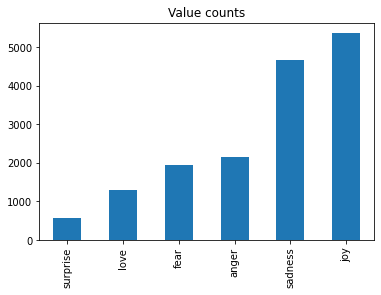

In [ ]:
import matplotlib.pyplot as plt

df['label_name'].value_counts(ascending=True).plot.bar()
plt.title("Value counts")
plt.show()

**The dataset is imbalanced, the suprise and love classes are the minority classes, their value counts can be increased by augmentation using some paraphrase generative models. But I am training the model on the dataset as it is.**

/usr/local/lib/python3.7/dist-packages/matplotlib/cbook/__init__.py:1376: VisibleDeprecationWarning: Creating an ndarray from ragged nested sequences (which is a list-or-tuple of lists-or-tuples-or ndarrays with different lengths or shapes) is deprecated. If you meant to do this, you must specify 'dtype=object' when creating the ndarray.
  X = np.atleast_1d(X.T if isinstance(X, np.ndarray) else np.asarray(X))


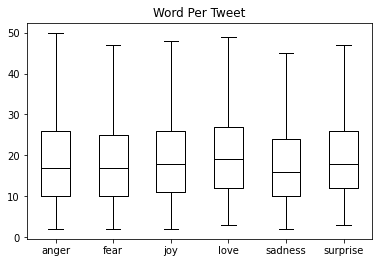

In [ ]:
df["Word Per Tweet"] = df["text"].str.split().apply(len)
df.boxplot("Word Per Tweet", by="label_name", grid=False, showfliers=False, color="black")
plt.suptitle("")
plt.xlabel("")
plt.show()

**since the maximum length of sentence per class is less than the max size of the tokens models can process, we will not loose any useful information.**

In [ ]:
emotions.reset_format()

**Loading tokenizer and tokenizing the entire dataset**

In [ ]:
from transformers import AutoTokenizer

model_ckpt = "distilbert-base-uncased"
tokenizer = AutoTokenizer.from_pretrained(model_ckpt)

Downloading:   0%|          | 0.00/28.0 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/483 [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/226k [00:00<?, ?B/s]

Downloading:   0%|          | 0.00/455k [00:00<?, ?B/s]

In [ ]:
def tokenize(batch):
    return tokenizer(batch['text'], padding=True, truncation=True)



In [ ]:
emotions_encoded = emotions.map(tokenize, batched=True, batch_size=False)

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

  0%|          | 0/1 [00:00<?, ?ba/s]

In [ ]:
emotions_encoded['train'].column_names


['text', 'label', 'input_ids', 'attention_mask']

In [ ]:
from transformers import AutoModel 

model_ckpt = "distilbert-base-uncased"

device = ("cuda" if torch.cuda.is_available() else "cpu")

In [ ]:
emotions_encoded.set_format("torch",columns=['input_ids','attention_mask',"label"])
emotions_encoded = emotions_encoded.rename_column("label", "labels")

In [ ]:
emotions_encoded['train'].column_names

['text', 'labels', 'input_ids', 'attention_mask']

In [ ]:
from torch.utils.data import DataLoader

data_collator = DataCollatorWithPadding(tokenizer=tokenizer)
train_dataloader = DataLoader(
    dataset=emotions_encoded['train'],
    batch_size=64,
    shuffle=True,
    collate_fn=data_collator
)

In [ ]:
valid_dataloader = DataLoader(
    dataset=emotions_encoded['validation'],
    batch_size=64,
    shuffle=True,
    collate_fn=data_collator
)

test_dataloader = DataLoader(
    dataset=emotions_encoded['test'],
    batch_size=64,
    shuffle=True,
    collate_fn=data_collator
)

In [ ]:
for batch in train_dataloader:
    break
{k: v.shape for k, v in batch.items()}

{'attention_mask': torch.Size([64, 87]),
 'input_ids': torch.Size([64, 87]),
 'labels': torch.Size([64])}

In [ ]:
num_classes = emotions_encoded['train'].features['labels'].num_classes

# Training

In [ ]:

model_ckpt = "distilbert-base-uncased"

device = ("cuda" if torch.cuda.is_available() else "cpu")

model = AutoModelForSequenceClassification.from_pretrained(model_ckpt, num_labels=num_classes).to(device)
device

Some weights of the model checkpoint at distilbert-base-uncased were not used when initializing DistilBertForSequenceClassification: ['vocab_projector.bias', 'vocab_transform.bias', 'vocab_transform.weight', 'vocab_projector.weight', 'vocab_layer_norm.bias', 'vocab_layer_norm.weight']
- This IS expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing DistilBertForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of DistilBertForSequenceClassification were not initialized from the model checkpoint at distilbert-base-uncased and are newly initialized: ['classifier.weight', 'classifier.bias', 'pre_classifier

'cuda'

In [ ]:
batch

outputs = model(**batch)
print(outputs.loss, outputs.logits.shape)

tensor(1.8039, device='cuda:0', grad_fn=<NllLossBackward0>) torch.Size([64, 6])


In [ ]:
torch.argmax(outputs.logits,dim=1)

tensor([4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4,
        4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4, 4], device='cuda:0')

In [ ]:
from transformers import AdamW

optimizer = AdamW(model.parameters(), lr=2e-5)

/usr/local/lib/python3.7/dist-packages/transformers/optimization.py:309: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  FutureWarning,


In [ ]:
from transformers import get_scheduler

num_epochs = 2
num_training_steps = num_epochs * len(train_dataloader)
lr_scheduler = get_scheduler(
    "linear",
    optimizer=optimizer,
    num_warmup_steps=0,
    num_training_steps=num_training_steps,
)
print(num_training_steps)

500


In [ ]:
from tqdm.auto import tqdm
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score

def compute_metrics(labels, preds):

    f1 = f1_score(labels, preds, average="weighted")
    acc = accuracy_score(labels, preds)
    precision = precision_score(labels, preds, average="weighted")
    recall = recall_score(labels, preds, average="weighted")
    return {"accuracy": acc, "f1": f1, "precision":precision, "recall": recall}

def train(model, train_dataloader, device, optimizer, lr_scheduler):
    model.train()
    losses = []
    for batch in train_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        outputs = model(**batch)
        loss = outputs.loss
        loss.backward()

        optimizer.step()
        lr_scheduler.step()
        optimizer.zero_grad()
        progress_bar.update(1)
        losses.append(loss.cpu().item())

    return np.mean(losses)


def validation(model, valid_dataloader, device):
    results = []
    model.eval()
    for batch in valid_dataloader:
        batch = {k: v.to(device) for k, v in batch.items()}
        with torch.no_grad():
            outputs = model(**batch)

        logits = outputs.logits
        predictions = torch.argmax(logits, dim=-1)
        metricscs = compute_metrics(batch['labels'].cpu(), predictions.cpu())
        
        metricscs['loss'] = outputs.loss.cpu().item()
        results.append(metricscs)
        progress_bar2.update(1)
    return results

In [ ]:
training_stats = []
progress_bar = tqdm(range(num_training_steps))
progress_bar2 = tqdm(range(num_epochs * len(valid_dataloader)))
for epoch in range(num_epochs):

    training_loss = train(model,train_dataloader, device, optimizer, lr_scheduler )

    results = validation(model, valid_dataloader, device)
    results = pd.DataFrame(results).mean().to_dict()
    results['epoch'] = epoch
    results['training_loss'] = training_loss
    training_stats.append(results)
 


  0%|          | 0/500 [00:00<?, ?it/s]

  0%|          | 0/64 [00:00<?, ?it/s]

/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/usr/local/lib/python3.7/dist-packages/sklearn/metrics/_classification.py:1318: UndefinedMetricWarning: Recall is ill-defined and 

In [ ]:
training_stats_df = pd.DataFrame(training_stats)
training_stats_df

,accuracy,f1,precision,recall,loss,epoch,training_loss
0,0.928223,0.929473,0.937612,0.928223,0.198225,0,0.182345
1,0.928223,0.929475,0.936481,0.928223,0.199296,1,0.183132


# Model evaluation

In [ ]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix

def plot_confusion_matrix(y_preds, y_true, labels):
    cm = confusion_matrix(y_true, y_preds, normalize="true")
    fig, ax = plt.subplots(figsize=(6, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
    disp.plot(cmap="Blues", values_format=".2f", ax=ax, colorbar=False)
    plt.title("Normalized confusion matrix")
    plt.show()


In [ ]:
from torch.nn.functional import cross_entropy

def forward_pass_with_label(batch):
    # Place all input tensors on the same device as the model
    inputs = {k:v.to(device) for k,v in batch.items()
              if k in tokenizer.model_input_names}

    with torch.no_grad():
        output = model(**inputs)
        pred_label = torch.argmax(output.logits, axis=-1)
        loss = cross_entropy(output.logits, batch["labels"].to(device),
                             reduction="none")
    # Place outputs on CPU for compatibility with other dataset columns
    return {"loss": loss.cpu().numpy(),
            "predicted_label": pred_label.cpu().numpy()}

In [ ]:

emotions_encoded.set_format("torch",columns=['input_ids','attention_mask',"labels"])


In [ ]:
# we use datasets map funtion to predict the classes and get losses

emotions_encoded["validation"] = emotions_encoded["validation"].map(
    forward_pass_with_label, batched=True, batch_size=16)

  0%|          | 0/125 [00:00<?, ?ba/s]

In [ ]:
emotions_encoded.set_format("pandas")
cols = ["text", "labels", "predicted_label", "loss"]
df_test = emotions_encoded["validation"][:][cols]
df_test["labels"] = df_test["labels"].apply(label_int2str)
df_test["predicted_label"] = (df_test["predicted_label"]
                              .apply(label_int2str))

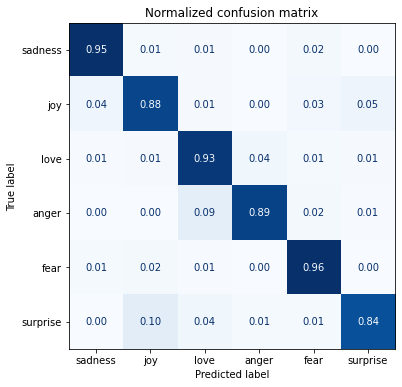

In [ ]:
labels = emotions["train"].features["label"].names
plot_confusion_matrix(df_test["predicted_label"], df_test["labels"], labels)

**The most confused class is "suprise", this is expected. since it is the minority class, let us do some manual inspection of predictions with highest losses.**

In [ ]:

from sklearn.metrics import classification_report

print(classification_report(df_test["labels"],df_test["predicted_label"]))


              precision    recall  f1-score   support

       anger       0.93      0.95      0.94       275
        fear       0.87      0.88      0.87       212
         joy       0.96      0.93      0.94       704
        love       0.85      0.89      0.87       178
     sadness       0.96      0.96      0.96       550
    surprise       0.79      0.84      0.81        81

    accuracy                           0.93      2000
   macro avg       0.89      0.91      0.90      2000
weighted avg       0.93      0.93      0.93      2000



In [ ]:
pd.set_option('display.max_colwidth' ,None)


**Inspecting the most confused predictions with respect to loss**

In [ ]:
df_test.sort_values("loss", ascending=False).head(10)

,text,labels,predicted_label,loss
1500,i guess we would naturally feel a sense of loneliness even the people who said unkind things to you might be missed,anger,sadness,5.328780
1801,i feel that he was being overshadowed by the supporting characters,love,sadness,5.222618
1963,i called myself pro life and voted for perry without knowing this information i would feel betrayed but moreover i would feel that i had betrayed god by supporting a man who mandated a barely year old vaccine for little girls putting them in danger to financially support people close to him,joy,sadness,5.089224
1870,i guess i feel betrayed because i admired him so much and for someone to do this to his wife and kids just goes beyond the pale,joy,sadness,5.073881
1950,i as representative of everything thats wrong with corporate america and feel that sending him to washington is a ludicrous idea,surprise,sadness,5.045858
1509,i guess this is a memoir so it feels like that should be fine too except i dont know something about such a deep amount of self absorption made me feel uncomfortable,joy,fear,4.722630
1111,im lazy my characters fall into categories of smug and or blas people and their foils people who feel inconvenienced by smug and or blas people,joy,fear,4.684596
1581,i feel stronger clearer but a little annoyed not quite sure why,anger,joy,4.522195
1683,i had applied for a job and they had assured me that the exams would take place a few months later a week later i went to obtain some more information and they told me that the exams had already taken place,anger,joy,4.398818
1741,i go home feeling simultaneously gutted and determined,joy,anger,4.271509


**We see the some of the texts are mislabbeled and our model seems to predicting them well.**

In [ ]:
df_test.sort_values("loss", ascending=True).head(10)


,text,labels,predicted_label,loss
1303,i feel pathetic and uninspired,sadness,sadness,0.011869
1965,i started feeling pathetic and ashamed,sadness,sadness,0.011882
1755,i feel depressed i am in despair why does it h...,sadness,sadness,0.011953
1452,i always feel guilty and come to one conclusio...,sadness,sadness,0.011974
69,i have no extra money im worried all of the ti...,sadness,sadness,0.012020
34,i feel that i m so pathetic and downright dumb...,sadness,sadness,0.012027
21,i feel try to tell me im ungrateful tell me im...,sadness,sadness,0.012039
1041,i suppose it all goes along with feeling unwel...,sadness,sadness,0.012045
396,i feel pretty pathetic now,sadness,sadness,0.012046
1152,i feel pathetic because i shouldn t complain a...,sadness,sadness,0.012073


In [ ]:
emotions_encoded.set_format("torch",columns=['input_ids','attention_mask',"labels"])


# Inference Improvement

In [ ]:
labels_mapping = {k:emotions['train'].features['label'].int2str(k) for k in range(6)}

In [ ]:
model_save_path = "/content/drive/MyDrive/simpllr"

model.save_pretrained(model_save_path)

# Further Improvements


1. Minority classes can be oversampled by adding new data or by augmenting using paraphrase generative models.

2. Different encoder type tranformers like RoBerta, Bert can be trained and benchmarked.

3. Hypermaters can be tuned using optuna for further optimization.


